In [1]:
import os
import yfinance as yf
import quantstats as qs
import scipy.cluster.hierarchy as sch
import cvxopt as opt
import matplotlib.pyplot as plt
import shutil
import base64
import cvxpy as cp

from scipy.stats import spearmanr
from io import BytesIO
from datetime import timedelta
from IPython.display import Image
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from cvxopt import blas, solvers
from IPython.display import display
from scipy.optimize import minimize
from matplotlib.backends.backend_svg import FigureCanvasSVG

from prep_factor import PrepFactor
from functions.utils.system import *
from functions.utils.func import *

import warnings

warnings.filterwarnings('ignore')

In [2]:
# Params
live = True
start = '2005-01-01'
current_date = date.today().strftime('%Y-%m-%d')
window = 60
threshold = 2_000_000_000
stock = read_stock(get_large_dir(live) / 'permno_live.csv')

In [3]:
# Read in Data
price = pd.read_parquet(get_parquet_dir(live) / 'data_price.parquet.brotli')
fund_q = pd.read_parquet(get_parquet_dir(live) / 'data_fund_raw_q.parquet.brotli')
rf = pd.read_parquet(get_parquet_dir(live) / 'data_rf.parquet.brotli')
ret_price = create_return(price, [1])

# Resample to daily
date_index = price.drop(price.columns, axis=1)
fund_q = date_index.merge(fund_q, left_index=True, right_index=True, how='left').groupby('permno').ffill()

# Factors

In [167]:
sb_sector = PrepFactor(live=live, factor_name='factor_sb_sector', group='permno', interval='D', kind='price', stock=stock, div=False, start=start, end=current_date, save=False).prep()
accrual = PrepFactor(live=live, factor_name='factor_accrual', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
comp_debt = PrepFactor(live=live, factor_name='factor_comp_debt', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
ret_comp = PrepFactor(live=live, factor_name='factor_ret_comp', group='permno', interval='D', kind='price', stock=stock, div=False, start=start, end=current_date, save=False).prep()
inv_growth = PrepFactor(live=live, factor_name='factor_inv_growth', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
pcttoacc = PrepFactor(live=live, factor_name='factor_pcttotacc', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
int_mom = PrepFactor(live=live, factor_name='factor_int_mom', group='permno', interval='D', kind='mom', stock=stock, div=False, start=start, end=current_date, save=False).prep()
mom_season = PrepFactor(live=live, factor_name='factor_mom_season', group='permno', interval='D', kind='mom', stock=stock, div=False, start=start, end=current_date, save=False).prep()
asset_growth = PrepFactor(live=live, factor_name='factor_asset_growth', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
chtax = PrepFactor(live=live, factor_name='factor_chtax', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=start, save=False).prep()
net_debt_finance = PrepFactor(live=live, factor_name='factor_net_debt_finance', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
noa = PrepFactor(live=live, factor_name='factor_noa', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
invest_ppe = PrepFactor(live=live, factor_name='factor_invest_ppe_inv', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
cheq = PrepFactor(live=live, factor_name='factor_cheq', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
xfin = PrepFactor(live=live, factor_name='factor_xfin', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
emmult = PrepFactor(live=live, factor_name='factor_emmult', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
grcapx = PrepFactor(live=live, factor_name='factor_grcapx', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()

Creating factor_sb_sector ---------------------------------- | ✔
Shape: (3104852, 32)
Creating factor_accrual ------------------------------------ | ✔
Shape: (3104852, 1)
Creating factor_comp_debt ---------------------------------- | ✔
Shape: (3104852, 1)
Creating factor_ret_comp ----------------------------------- | ✔
Shape: (3104852, 5)
Creating factor_inv_growth --------------------------------- | ✔
Shape: (3104852, 1)
Creating factor_pcttotacc ---------------------------------- | ✔
Shape: (3104852, 1)
Creating factor_int_mom ------------------------------------ | ✔
Shape: (3104852, 1)
Creating factor_mom_season --------------------------------- | ✔
Shape: (3104852, 1)
Creating factor_asset_growth ------------------------------- | ✔
Shape: (3104852, 1)
Creating factor_chtax -------------------------------------- | ✔
Shape: (0, 1)
Creating factor_net_debt_finance --------------------------- | ✔
Shape: (3104852, 1)
Creating factor_noa ---------------------------------------- | ✔
Shape

In [470]:
mom_season_short = PrepFactor(live=live, factor_name='factor_mom_season_short', group='permno', interval='D', kind='mom', stock=stock, div=False, start=start, end=current_date, save=False).prep()
mom_vol = PrepFactor(live=live, factor_name='factor_mom_vol', group='permno', interval='D', kind='mom', stock=stock, div=False, start=start, end=current_date, save=False).prep()
mom_off_season = PrepFactor(live=live, factor_name='factor_mom_off_season', group='permno', interval='D', kind='mom', stock=stock, div=False, start=start, end=current_date, save=False).prep()
mom_season6 = PrepFactor(live=live, factor_name='factor_mom_season6', group='permno', interval='D', kind='mom', stock=stock, div=False, start=start, end=current_date, save=False).prep()
mom_season11 = PrepFactor(live=live, factor_name='factor_mom_season11', group='permno', interval='D', kind='mom', stock=stock, div=False, start=start, end=current_date, save=False).prep()

Creating factor_mom_season_short --------------------------- | ✔
Shape: (3104852, 1)
Creating factor_mom_vol ------------------------------------ | ✔
Shape: (3104852, 1)
Creating factor_mom_off_season ----------------------------- | ✔
Shape: (3104852, 1)
Creating factor_mom_season6 -------------------------------- | ✔
Shape: (3104852, 1)
Creating factor_mom_season11 ------------------------------- | ✔
Shape: (3104852, 1)


In [513]:
load_ret = PrepFactor(live=live, factor_name='factor_load_ret', group='permno', interval='D', kind='loading', stock=stock, div=False, start=start, end=current_date, save=False).prep()

Creating factor_load_ret ----------------------------------- | ✔
Shape: (3105599, 5)


In [546]:
load_volume = PrepFactor(live=live, factor_name='factor_load_volume', group='permno', interval='D', kind='loading', stock=stock, div=False, start=start, end=current_date, save=False).prep()

Creating factor_load_volume -------------------------------- | ✔
Shape: (3105513, 5)


# Mom

In [331]:
def create_multi_index(factor_data, stock):
    factor_values = pd.concat([factor_data] * len(stock), ignore_index=True).values
    multi_index = pd.MultiIndex.from_product([stock, factor_data.index])
    multi_index_factor = pd.DataFrame(factor_values, columns=factor_data.columns, index=multi_index)
    multi_index_factor.index = multi_index_factor.index.set_names(['permno', 'date'])
    return multi_index_factor

In [332]:
# Create momentum weights
rf_df = create_multi_index(rf, stock)
mom = price.merge(rf_df, left_index=True, right_index=True, how='left').ffill()
mom = create_return(mom, [1])

In [333]:
def calculate_rolling_momentum(stock_data):
    # Calculate excess return
    stock_data['excess_return'] = stock_data['RET_01'] - stock_data['RF']

    # Calculate the 12-month rolling cumulative excess return, excluding the most recent month
    shifted_excess_return = stock_data['excess_return'].shift(1)
    rolling_momentum = shifted_excess_return.rolling(window=21).sum()

    return rolling_momentum

In [334]:
# Calculate rolling momentum for each stock
mom['mom'] = mom.groupby(level='permno').apply(calculate_rolling_momentum).reset_index(level=0, drop=True)

# Standard Rank

In [547]:
factor = (pd.merge(ret_price, sb_sector, left_index=True, right_index=True, how='left')
          .merge(accrual, left_index=True, right_index=True, how='left')
          .merge(comp_debt, left_index=True, right_index=True, how='left')
          .merge(ret_comp, left_index=True, right_index=True, how='left')
          .merge(inv_growth, left_index=True, right_index=True, how='left')
          .merge(pcttoacc, left_index=True, right_index=True, how='left')
          .merge(int_mom, left_index=True, right_index=True, how='left')
          .merge(mom_season, left_index=True, right_index=True, how='left')
          .merge(asset_growth, left_index=True, right_index=True, how='left')
          .merge(chtax, left_index=True, right_index=True, how='left')
          .merge(net_debt_finance, left_index=True, right_index=True, how='left')
          .merge(noa, left_index=True, right_index=True, how='left')
          .merge(invest_ppe, left_index=True, right_index=True, how='left')
          .merge(cheq, left_index=True, right_index=True, how='left')
          .merge(xfin, left_index=True, right_index=True, how='left')
          .merge(emmult, left_index=True, right_index=True, how='left')
          .merge(grcapx, left_index=True, right_index=True, how='left')
          .merge(mom[['mom']], left_index=True, right_index=True, how='left')
          .merge(mom_season_short, left_index=True, right_index=True, how='left')
          .merge(mom_off_season, left_index=True, right_index=True, how='left')
          .merge(mom_season6, left_index=True, right_index=True, how='left')
          .merge(mom_season11, left_index=True, right_index=True, how='left')
          .merge(load_ret, left_index=True, right_index=True, how='left')
          .merge(load_volume, left_index=True, right_index=True, how='left'))

In [548]:
factor.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'RET_01',
       'ALPHA_sector_01_21', 'XLB_RET_01_sector_01_21',
       'XLE_RET_01_sector_01_21', 'XLF_RET_01_sector_01_21',
       'XLI_RET_01_sector_01_21', 'XLK_RET_01_sector_01_21',
       'XLP_RET_01_sector_01_21', 'XLU_RET_01_sector_01_21',
       'XLV_RET_01_sector_01_21', 'XLY_RET_01_sector_01_21',
       'epsil_sector_01_21', 'pred_sector_01_21', 'resid_mom_21_sector_01_21',
       'resid_mom_126_sector_01_21', 'idio_vol_21_sector_01_21',
       'idio_vol_126_sector_01_21', 'ALPHA_sector_01_126',
       'XLB_RET_01_sector_01_126', 'XLE_RET_01_sector_01_126',
       'XLF_RET_01_sector_01_126', 'XLI_RET_01_sector_01_126',
       'XLK_RET_01_sector_01_126', 'XLP_RET_01_sector_01_126',
       'XLU_RET_01_sector_01_126', 'XLV_RET_01_sector_01_126',
       'XLY_RET_01_sector_01_126', 'epsil_sector_01_126', 'pred_sector_01_126',
       'resid_mom_21_sector_01_126', 'resid_mom_126_sector_01_126',
       'idio_vol_21_sector_01_126', 'i

In [549]:
factor['accruals'] = factor.groupby('permno')['accruals'].ffill()
factor['comp_debt_iss'] = factor.groupby('permno')['comp_debt_iss'].ffill()
factor['inv_growth'] = factor.groupby('permno')['inv_growth'].ffill()
factor['asset_growth'] = factor.groupby('permno')['asset_growth'].ffill()
factor['chtax'] = factor.groupby('permno')['chtax'].ffill()
factor['net_debt_fin'] = factor.groupby('permno')['net_debt_fin'].ffill()
factor['noa'] = factor.groupby('permno')['noa'].ffill()
factor['invest_ppe_inv'] = factor.groupby('permno')['invest_ppe_inv'].ffill()
factor['cheq'] = factor.groupby('permno')['cheq'].ffill()
factor['pct_tot_acc'] = factor.groupby('permno')['pct_tot_acc'].ffill()
factor['xfin'] = factor.groupby('permno')['xfin'].ffill()
factor['emmult'] = factor.groupby('permno')['emmult'].ffill()
factor['grcapx'] = factor.groupby('permno')['grcapx'].ffill()
factor['grcapx1y'] = factor.groupby('permno')['grcapx1y'].ffill()
factor['grcapx3y'] = factor.groupby('permno')['grcapx3y'].ffill()

In [550]:
# Add market_cap
market = pd.read_parquet(get_parquet_dir(live) / 'data_misc.parquet.brotli', columns=['market_cap'])

# # Resample to monthly
# market = month(market)

factor = factor.merge(market, left_index=True, right_index=True, how='left')

# Fundamental

In [615]:
df = factor.copy(deep=True)

In [616]:
# Filtering by Market Capitalization
df = df[df['market_cap'] >= threshold]

In [665]:
# Ranking Securities within Each Factor
factors = [
    "XLB_RET_01_sector_01_126",
    "XLE_RET_01_sector_01_126",
    "XLF_RET_01_sector_01_126",
    "XLI_RET_01_sector_01_126",
    "XLK_RET_01_sector_01_126",
    "XLP_RET_01_sector_01_126",
    "XLU_RET_01_sector_01_126",
    "XLV_RET_01_sector_01_126",
    "XLY_RET_01_sector_01_126",
    "accruals",
    "comp_debt_iss",
    "ret_comp_21",
    "ret_comp_126",
    "ret_comp_252"
]

# Ranking Securities within Each Factor
factors = [
    "accruals",
    "comp_debt_iss",
    "ret_comp_21",
    "ret_comp_126",
    "ret_comp_252",
    "inv_growth"
]

# Ranking Securities within Each Factor
factors = [
    "accruals",
    "inv_growth",
    "comp_debt_iss",
    "pct_tot_acc",
    'asset_growth', 
    'chtax', 
    'net_debt_fin', 
    'noa',
    'invest_ppe_inv', 
    'cheq', 
    'xfin', 
    'emmult', 
    'grcapx'
]

# Ranking Securities within Each Factor
factors = [
    "accruals",
    "inv_growth",
    "comp_debt_iss",
    "pct_tot_acc",
    'chtax',
]

# # Ranking Securities within Each Factor
# factors = [
#     'load_ret_1', 
#     'load_ret_2', 
#     'load_ret_3', 
#     'load_ret_4',
#     'load_ret_5',
#     'load_ret_5', 
#     "mom_season",
#     "mom_season_short",
#     "mom_season_6"
# ]

for factor_name in factors:
    print(factor_name)
    df[f'{factor_name}_Rank'] = df.groupby('date')[factor_name].rank(ascending=False)

accruals
inv_growth
comp_debt_iss
pct_tot_acc
chtax


In [666]:
# Calculating Average Rank
df['avg_rank'] = df[[f'{f}_Rank' for f in factors]].mean(axis=1)

In [667]:
# Calculating rank weights
df['rank_weight'] = (1 / len(factors)) * df['avg_rank']

In [668]:
df['rank_weight'] = df['rank_weight'].groupby('permno').shift(1)

In [669]:
# Calculating inverse volatility (using past 36 months)
df['vol'] = df.groupby('permno')['RET_01'].transform(lambda x: x.rolling(21).std())
df['inv_vol_weight'] = 1 / df['vol']

In [670]:
# Find adjusted weight that accounts for rank and inverse volatility
df['adj_weight'] = df['rank_weight'] * df['inv_vol_weight']

In [671]:
# Function to select top and bottom stocks
def select_top_bottom_stocks(group):
    top_stocks = group.nlargest(25, 'adj_weight')
    bottom_stocks = group.nsmallest(25, 'adj_weight')
    top_stocks['final_weight'] = top_stocks['adj_weight'] * 1
    bottom_stocks['final_weight'] = bottom_stocks['adj_weight'] * -1
    return pd.concat([top_stocks, bottom_stocks])

In [672]:
# Selecting Top and Bottom Stocks
top_bottom_stocks = df.groupby('date').apply(select_top_bottom_stocks).reset_index(level=0, drop=True)

In [673]:
# Normalizing Weights
top_bottom_stocks['final_weight'] /= top_bottom_stocks.groupby('date')['final_weight'].transform(lambda x: x.abs().sum())

In [674]:
top_bottom_stocks['total_ret'] = top_bottom_stocks['RET_01'] * top_bottom_stocks['final_weight']

In [675]:
total_ret = top_bottom_stocks.groupby('date').total_ret.sum()

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2008-03-03   2008-03-03
End Period                 2023-11-10   2023-11-10
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          229.26%      337.42%
CAGR﹪                     5.38%        6.71%

Sharpe                     0.47         1.12
Prob. Sharpe Ratio         96.94%       100.0%
Smart Sharpe               0.45         1.07
Sortino                    0.66         1.57
Smart Sortino              0.63         1.5
Sortino/√2                 0.47         1.11
Smart Sortino/√2           0.45         1.06
Omega                      1.24         1.24

Max Drawdown               -52.39%      -32.74%
Longest DD Days            1570         1070
Volatility (ann.)          20.47%       8.75%
R^2                        0.71         0.71
Information Ratio          0.0          0.0
Calmar               

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-06-06,2009-03-09,2011-05-11,1070,-32.739909,-30.380490
2,2020-02-18,2020-03-23,2020-07-31,165,-18.294707,-14.892684
3,2011-05-20,2011-08-10,2011-10-20,154,-10.160721,-8.271776
4,2022-04-22,2022-06-17,2022-11-23,216,-8.069919,-7.213947
5,2022-12-05,2023-03-10,2023-04-24,141,-5.509077,-5.373666


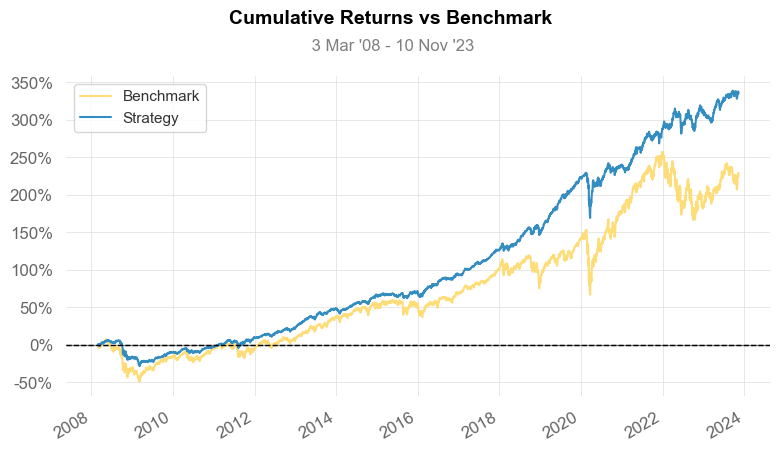

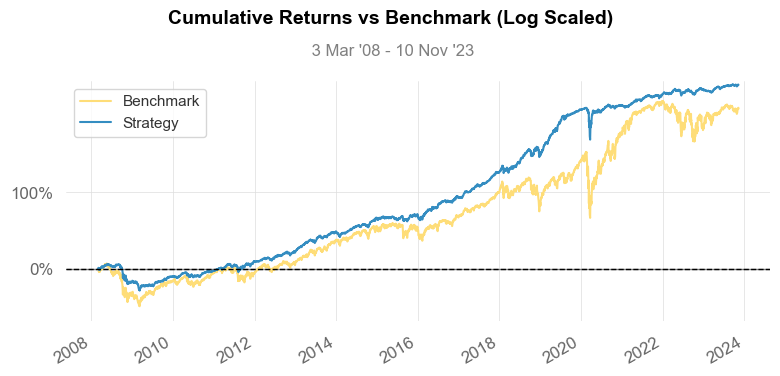

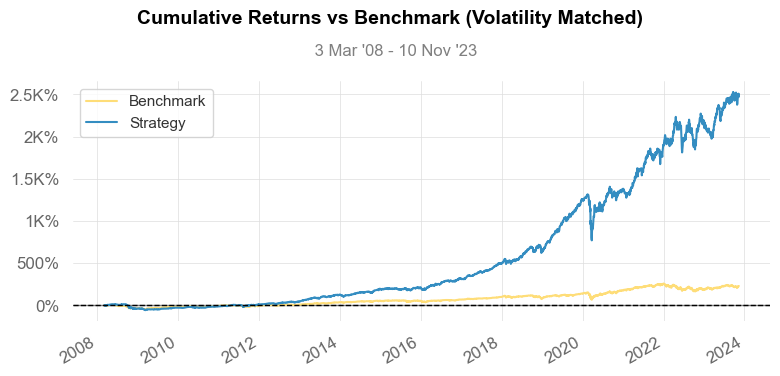

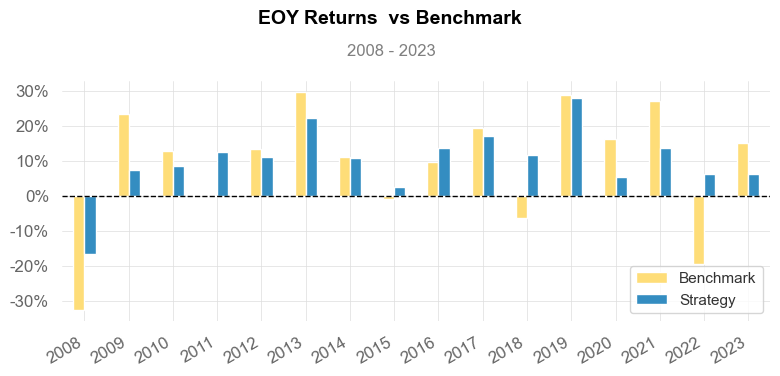

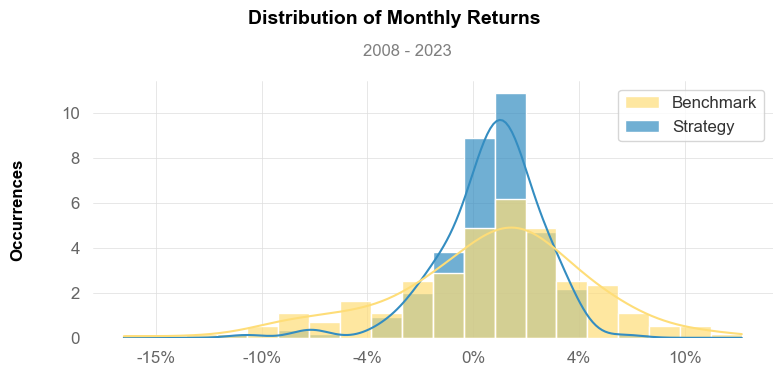

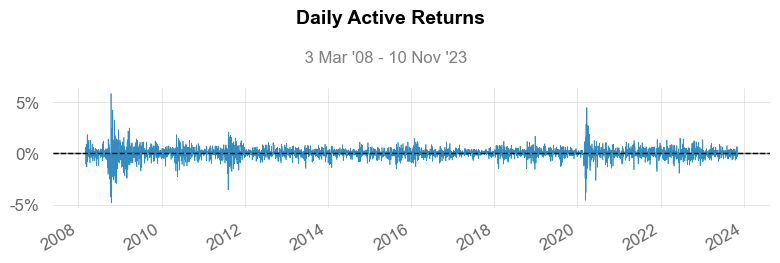

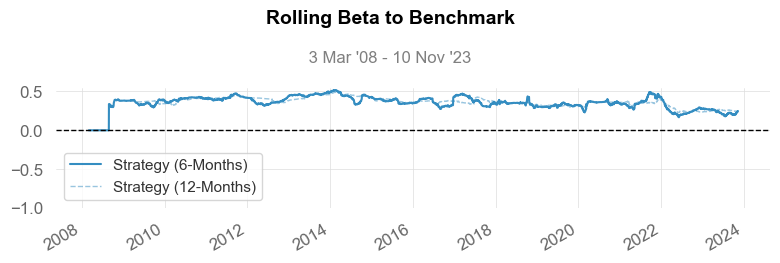

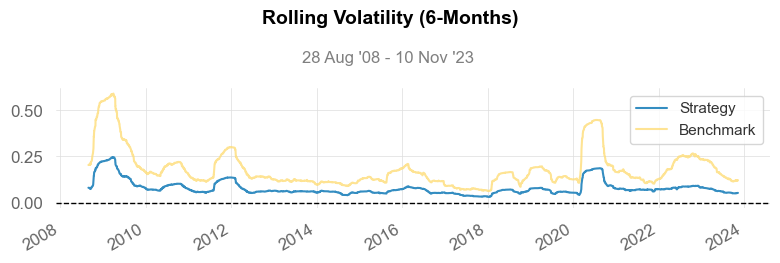

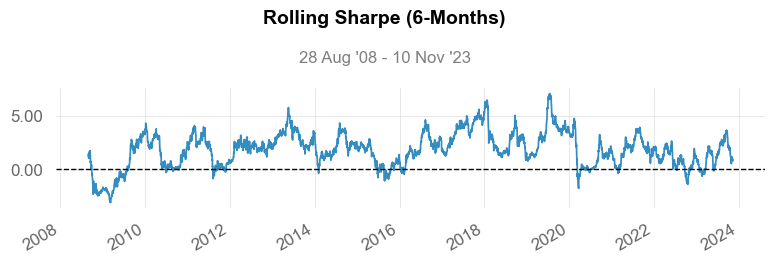

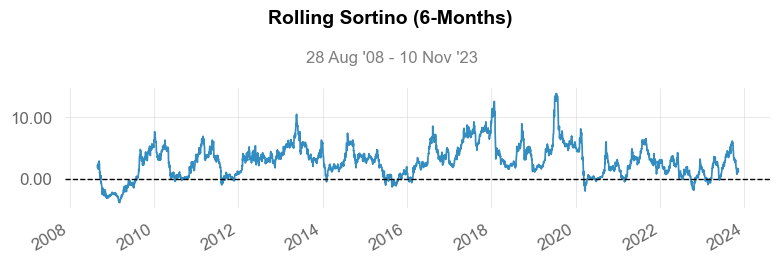

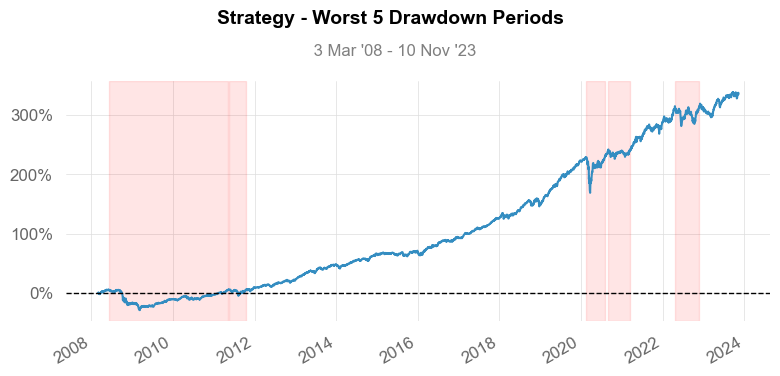

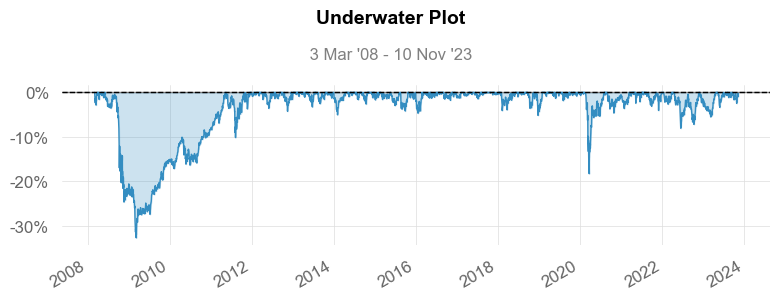

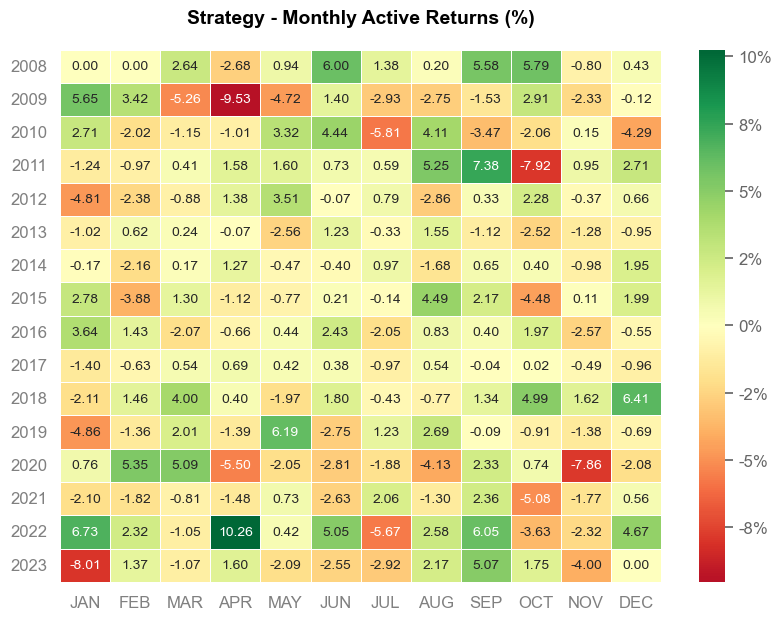

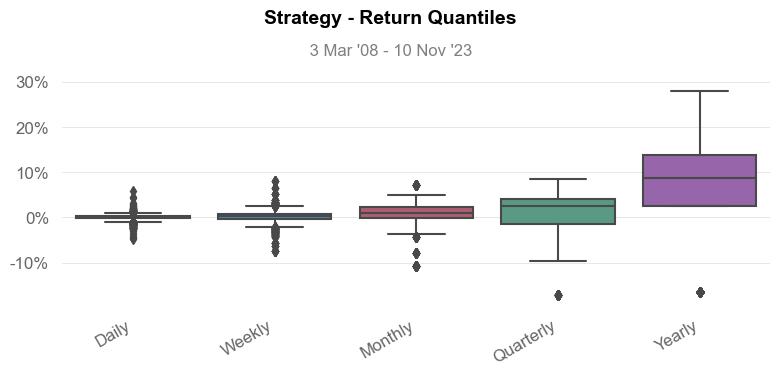

In [676]:
qs.reports.full(total_ret, 'SPY')

# Momentum

In [677]:
df = factor.copy(deep=True)

In [678]:
# Filtering by Market Capitalization
df = df[df['market_cap'] >= threshold]

In [679]:
# Ranking Securities within Each Factor
factors = [
    "XLB_RET_01_sector_01_126",
    "XLE_RET_01_sector_01_126",
    "XLF_RET_01_sector_01_126",
    "XLI_RET_01_sector_01_126",
    "XLK_RET_01_sector_01_126",
    "XLP_RET_01_sector_01_126",
    "XLU_RET_01_sector_01_126",
    "XLV_RET_01_sector_01_126",
    "XLY_RET_01_sector_01_126",
    "accruals",
    "comp_debt_iss",
    "ret_comp_21",
    "ret_comp_126",
    "ret_comp_252"
]

# Ranking Securities within Each Factor
factors = [
    "accruals",
    "comp_debt_iss",
    "ret_comp_21",
    "ret_comp_126",
    "ret_comp_252",
    "inv_growth"
]

# Ranking Securities within Each Factor
factors = [
    "accruals",
    "inv_growth",
    "comp_debt_iss",
    "pct_tot_acc",
    'asset_growth', 
    'chtax', 
    'net_debt_fin', 
    'noa',
    'invest_ppe_inv', 
    'cheq', 
    'xfin', 
    'emmult', 
    'grcapx'
]

# Ranking Securities within Each Factor
factors = [
    "accruals",
    "inv_growth",
    "comp_debt_iss",
    "pct_tot_acc",
    'chtax',
]

# Ranking Securities within Each Factor
factors = [
    'load_ret_1', 
    'load_ret_2', 
    'load_ret_3', 
    'load_ret_4',
    'load_ret_5',
    'load_ret_5', 
    "mom_season",
    "mom_season_short",
    "mom_season_6"
]

for factor_name in factors:
    print(factor_name)
    df[f'{factor_name}_Rank'] = df.groupby('date')[factor_name].rank(ascending=False)

load_ret_1
load_ret_2
load_ret_3
load_ret_4
load_ret_5
load_ret_5
mom_season
mom_season_short
mom_season_6


In [680]:
# Calculating Average Rank
df['avg_rank'] = df[[f'{f}_Rank' for f in factors]].mean(axis=1)

In [681]:
# Calculating rank weights
df['rank_weight'] = (1 / len(factors)) * df['avg_rank']

In [682]:
df['rank_weight'] = df['rank_weight'].groupby('permno').shift(1)

In [683]:
# Calculating inverse volatility (using past 36 months)
df['vol'] = df.groupby('permno')['RET_01'].transform(lambda x: x.rolling(21).std())
df['inv_vol_weight'] = 1 / df['vol']

In [684]:
# Find adjusted weight that accounts for rank and inverse volatility
df['adj_weight'] = df['rank_weight'] * df['inv_vol_weight']

In [685]:
# Function to select top and bottom stocks
def select_top_bottom_stocks(group):
    top_stocks = group.nlargest(25, 'adj_weight')
    bottom_stocks = group.nsmallest(25, 'adj_weight')
    top_stocks['final_weight'] = top_stocks['adj_weight'] * 1
    bottom_stocks['final_weight'] = bottom_stocks['adj_weight'] * -1
    return pd.concat([top_stocks, bottom_stocks])

In [686]:
# Selecting Top and Bottom Stocks
top_bottom_stocks = df.groupby('date').apply(select_top_bottom_stocks).reset_index(level=0, drop=True)

In [687]:
# Normalizing Weights
top_bottom_stocks['final_weight'] /= top_bottom_stocks.groupby('date')['final_weight'].transform(lambda x: x.abs().sum())

In [688]:
top_bottom_stocks['total_ret'] = top_bottom_stocks['RET_01'] * top_bottom_stocks['final_weight']

In [689]:
total_ret = top_bottom_stocks.groupby('date').total_ret.sum()

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2008-01-03   2008-01-03
End Period                 2023-11-10   2023-11-10
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          204.02%      207.5%
CAGR﹪                     4.96%        5.01%

Sharpe                     0.45         1.01
Prob. Sharpe Ratio         96.16%       100.0%
Smart Sharpe               0.42         0.96
Sortino                    0.62         1.44
Smart Sortino              0.6          1.37
Sortino/√2                 0.44         1.02
Smart Sortino/√2           0.42         0.97
Omega                      1.19         1.19

Max Drawdown               -52.98%      -37.7%
Longest DD Days            1714         1836
Volatility (ann.)          20.47%       7.31%
R^2                        0.34         0.34
Information Ratio          -0.01        -0.01
Calmar              

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-01-10,2009-05-22,2013-01-18,1836,-37.699297,-36.733935
2,2020-02-19,2020-03-23,2020-04-13,55,-10.797778,-9.902709
3,2020-09-10,2021-02-26,2021-04-19,222,-7.684406,-7.441226
4,2018-02-02,2018-03-23,2018-07-05,154,-6.383321,-5.391306
5,2020-04-21,2020-06-12,2020-07-13,84,-5.437855,-5.315220


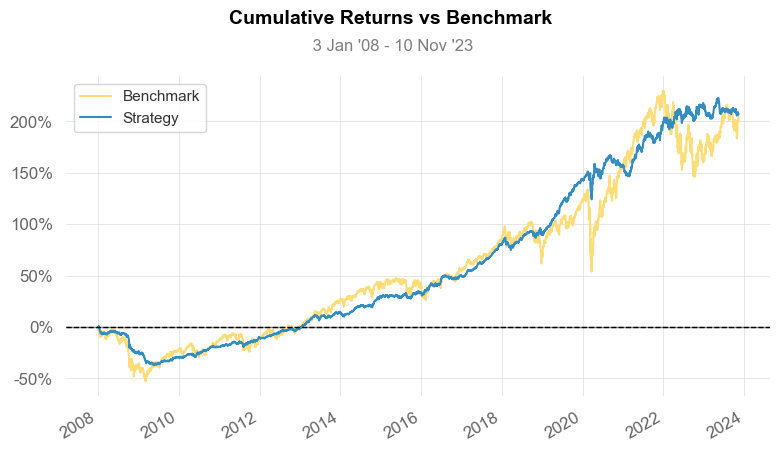

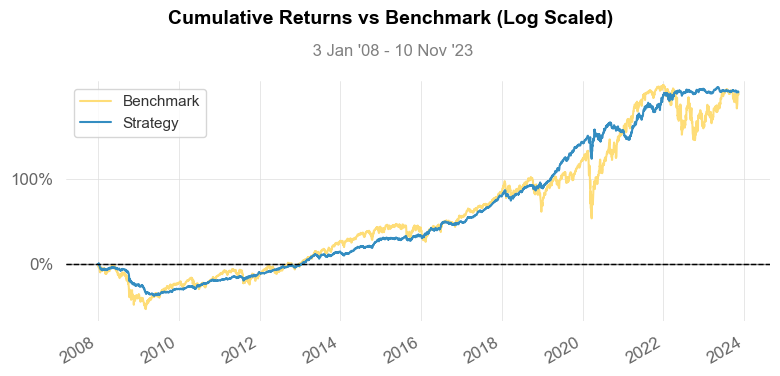

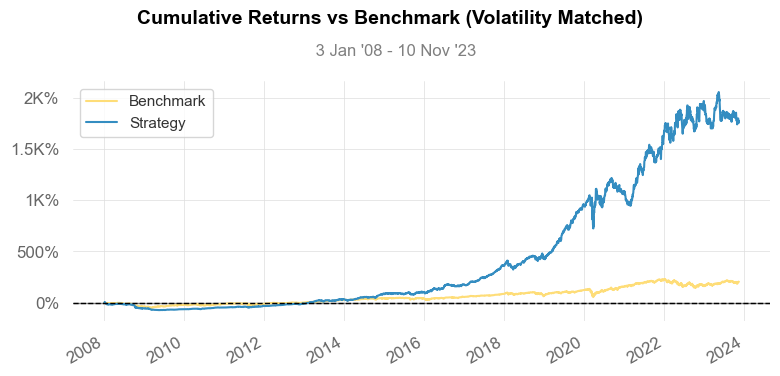

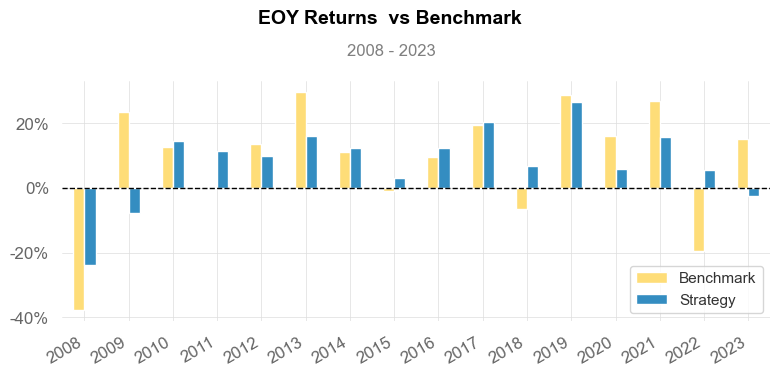

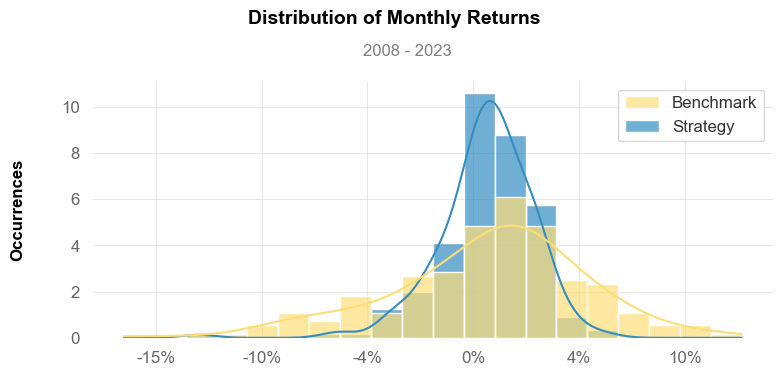

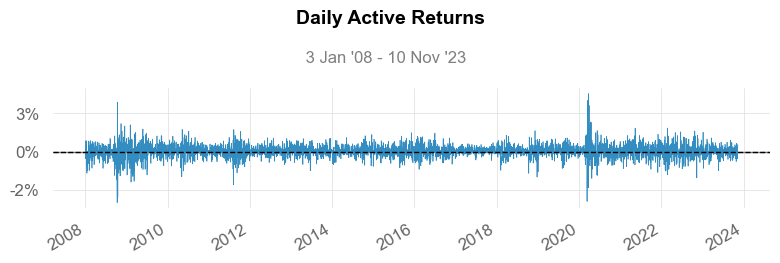

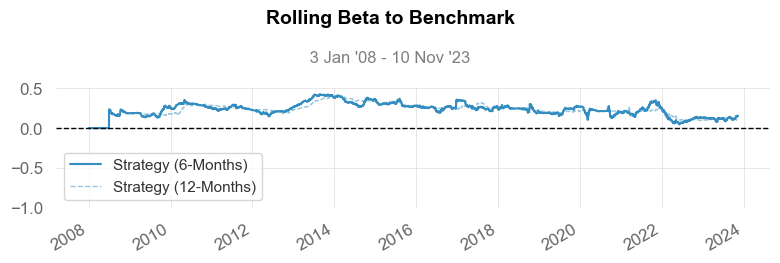

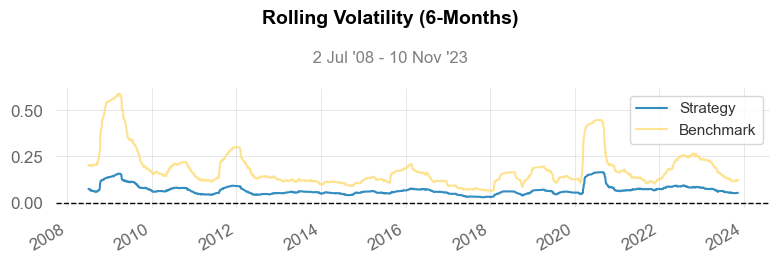

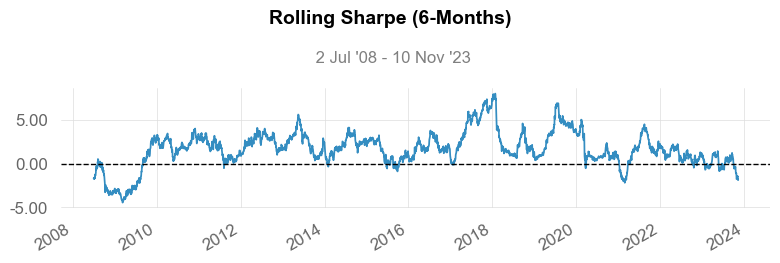

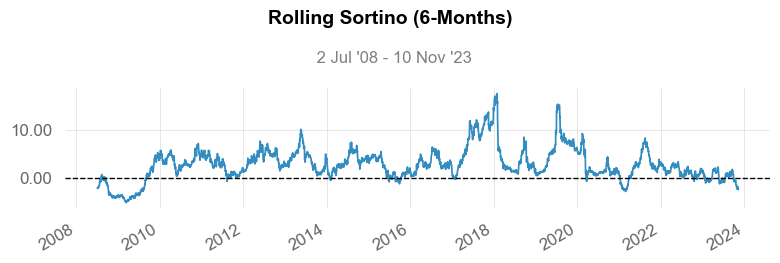

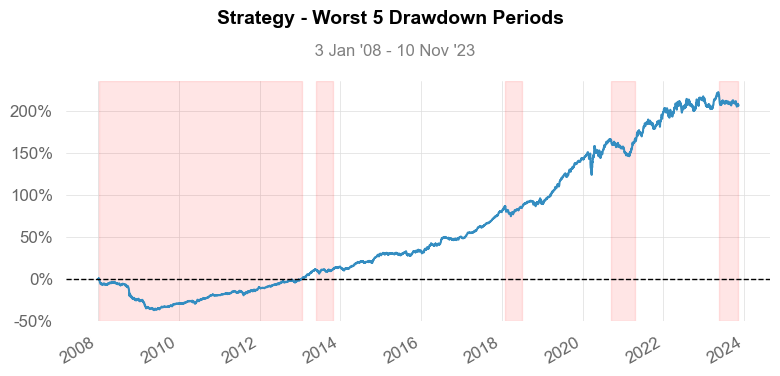

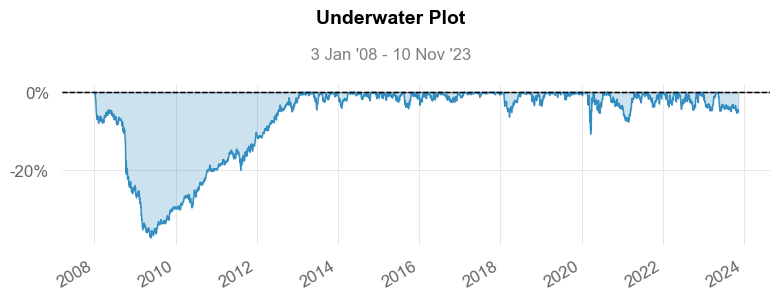

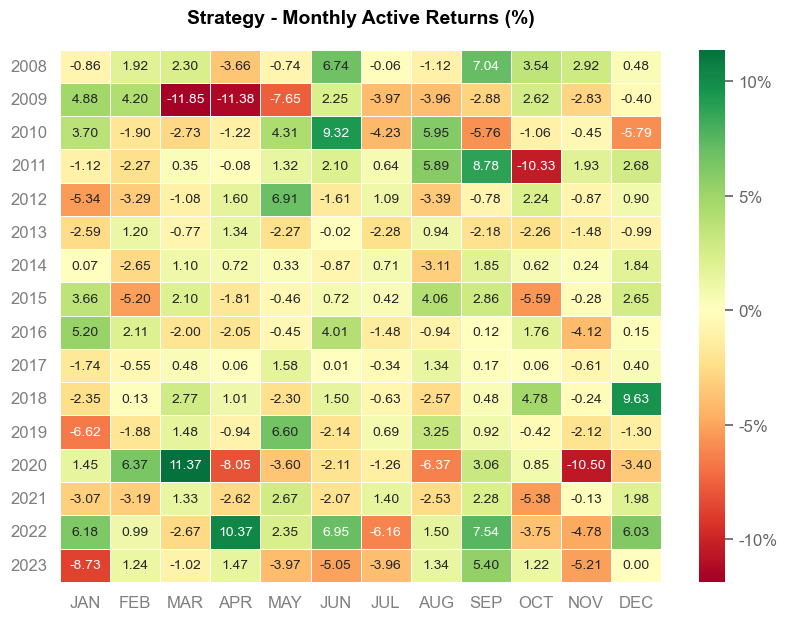

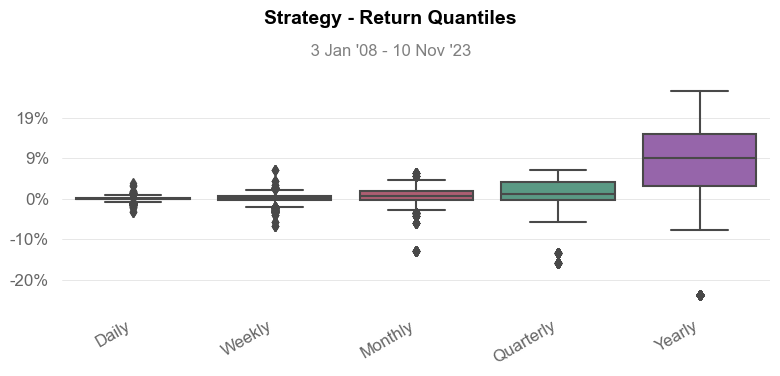

In [690]:
qs.reports.full(total_ret, 'SPY')